In [1]:
import numpy as np
from cvxopt import matrix, solvers

Dynamics of the form $$x_{t+1} = A_t x_t + B_t u_t$$
with $$\|u_t\|_\infty \leq u_{max},\,\, t=1,\ldots,T$$
and stage-wise cost $$c(x_t,u_t) = x_t^T Q_t x_t$$

In [3]:
T = 40
state_dim = 4
ac_dim = 2
control_limit = 10.
dt = 0.1

Q = np.diag([1.,1.,0.2,0.2])

x0 = np.ones((4,1))
x0[0,0] = 5.

# double integrator dynamics
A = np.eye(4)
A[0,2] = dt
A[1,3] = dt

B = np.zeros((4,2))
B[2,0] = dt
B[3,1] = dt

# add some random stuff to the dynamics
A = A + np.random.randn(4,4)*0.1


# build state matrices
A_block = np.zeros((state_dim*(T+1),ac_dim*T))
for t in range(T+1):
    for k in range(t):
        A_block[state_dim*t:state_dim*(t+1), ac_dim*k:ac_dim*(k+1)] = np.linalg.matrix_power(A,t-k-1) @ B

# build offset matrix
c = np.zeros((state_dim*(T+1),1))
for t in range(T+1):
    c[state_dim*t:state_dim*(t+1)] = np.linalg.matrix_power(A,t) @ x0
    
Q_block = np.zeros((state_dim*(T+1), state_dim*(T+1)))#matrix(0.,(state_dim*T, state_dim*T))
for t in range(T+1):
    Q_block[state_dim*t:state_dim*(t+1),state_dim*t:state_dim*(t+1)] = Q
    
# build constraint matrix
G = np.zeros((T*ac_dim*2,T*ac_dim))
h = np.ones((T*ac_dim*2))*control_limit

for t in range(T):
    G[t*ac_dim:(t+1)*ac_dim,t*ac_dim:(t+1)*ac_dim] = np.eye(ac_dim)
    G[(T+t)*ac_dim:(T+t+1)*ac_dim,(t)*ac_dim:(t+1)*ac_dim] = -np.eye(ac_dim)
    

# CVXOPT

In [4]:
quad_cost = matrix(A_block.T @ Q_block @ A_block)
linear_cost = matrix((c.T @ Q_block @ A_block).T)
const_cost = c.T @ Q_block @ c

G_mat = matrix(G)
h_mat = matrix(h)

In [5]:
hmat2 = matrix(control_limit, (T*ac_dim,1))

In [6]:
sol = solvers.qp(quad_cost, linear_cost, G_mat, h_mat)

     pcost       dcost       gap    pres   dres
 0: -5.1223e+01 -3.2760e+03  3e+03  5e-17  7e-16
 1: -9.3013e+01 -4.5137e+02  4e+02  2e-16  3e-16
 2: -1.0566e+02 -1.3871e+02  3e+01  2e-16  3e-16
 3: -1.0869e+02 -1.1242e+02  4e+00  2e-16  2e-16
 4: -1.0919e+02 -1.0962e+02  4e-01  2e-16  2e-16
 5: -1.0928e+02 -1.0933e+02  6e-02  2e-16  2e-16
 6: -1.0929e+02 -1.0929e+02  3e-03  2e-16  2e-16
 7: -1.0929e+02 -1.0929e+02  6e-05  2e-16  3e-16
Optimal solution found.


In [7]:
sol

{'dual infeasibility': 3.1371870382943995e-16,
 'dual objective': -109.29294309452632,
 'dual slack': 5.0704166143211265e-09,
 'gap': 6.131896440654007e-05,
 'iterations': 7,
 'primal infeasibility': 1.87835011159719e-16,
 'primal objective': -109.29288177556191,
 'primal slack': 7.750948185816995e-07,
 'relative gap': 5.610517666874359e-07,
 's': <160x1 matrix, tc='d'>,
 'status': 'optimal',
 'x': <80x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 'z': <160x1 matrix, tc='d'>}

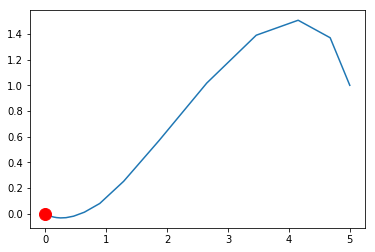

In [10]:
# viz system
import matplotlib.pyplot as plt

x = np.zeros((state_dim,T+1))
x[:,0:1] = x0

u = np.zeros((ac_dim,T))

for t in range(T):
    u0 = sol['x'][ac_dim*t]
    u1 = sol['x'][ac_dim*t+1]
    u[:,t] = np.array([u0, u1])
    x[:,(t+1):(t+2)] = A @ x[:,t:(t+1)] + B @ u[:,t:t+1]
    
plt.plot(x[0,:],x[1,:])
plt.plot(x[0,-1],x[1,-1],marker='o',color='r',markersize=12)
plt.show()

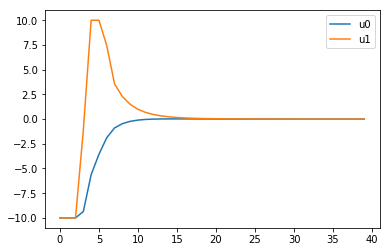

In [9]:
plt.plot(np.linspace(0,T-1,T),u[0,:])
plt.plot(np.linspace(0,T-1,T),u[1,:])
plt.legend(['u0','u1'])
plt.show()

# CVXPY

We will now replace our control constraint with $$\|u_t\|_2 \leq u_{max},\,\, t=1,\ldots,T$$
which gives us a quadratically-constrained quadratic program (QCQP)

In [11]:
import cvxpy as cp
u = cp.Variable(ac_dim*T)
cost = cp.quad_form(u,0.5*A_block.T @ Q_block @ A_block) + cp.sum((c.T @ Q_block @ A_block) @ u)
objective = cp.Minimize(cost)
constraints = []
for t in range(T):
    constraints.append(cp.norm(u[ac_dim*t:ac_dim*(t+1)],2)<=control_limit*np.sqrt(2))
prob = cp.Problem(objective,constraints)
prob.solve()

-110.2392170087437

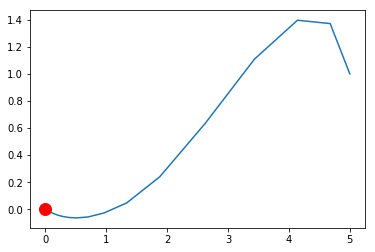

In [12]:
x = np.zeros((state_dim,T+1))
x[:,0:1] = x0

umat = np.zeros((ac_dim,T))

for t in range(T):
    u0 = u.value[ac_dim*t]
    u1 = u.value[ac_dim*t+1]
    umat[:,t] = np.array([u0, u1])
    x[:,(t+1):(t+2)] = A @ x[:,t:(t+1)] + B @ umat[:,t:t+1]
    
plt.plot(x[0,:],x[1,:])
plt.plot(x[0,-1],x[1,-1],marker='o',color='r',markersize=12)
plt.show()

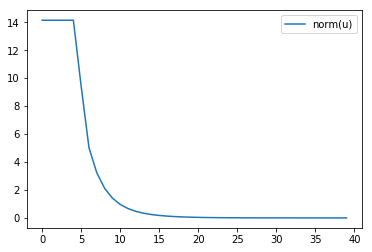

In [13]:
plt.plot(np.linspace(0,T-1,T),np.sqrt(umat[0,:]**2 + umat[1,:]**2))
plt.legend(['norm(u)'])
plt.show()

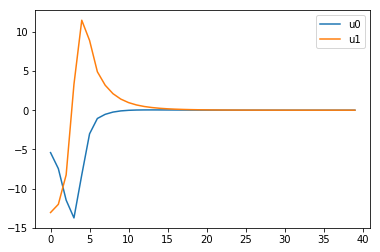

In [14]:
plt.plot(np.linspace(0,T-1,T),umat[0,:])
plt.plot(np.linspace(0,T-1,T),umat[1,:])
plt.legend(['u0','u1'])
plt.show()